# Climatology generator demo sandbox

Date: 13 Novebmer, 2023

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is 16TB of data over nearly 9000 `netcdf` file assests in total.

#### required packages

In [6]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#more plotting
import matplotlib.dates as mdates
import seaborn as sns

#### start a local Dask client

In [2]:
from dask.distributed import Client
#client = Client(threads_per_worker=1)
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42119,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:35417,Total threads: 4
Dashboard: /proxy/41751/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:42241,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

# ARD workflow

### read paths from config file

#### [ you will need to specifiy your correct path for the `data-catalogue/config.ini` file ]

In [ ]:
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config file
#########
#### you will need to specifiy your correct path the the `data-catalogue/config.ini` file 
#########
config.read('./code/BRAN2020-intake-catalog/config.ini')

# Get the value of a variable
catalog_path = config.get('paths', 'catalog_path')

In [ ]:
catalog_path

In [ ]:
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json',columns_with_iterables=['variable'])

In [ ]:
BRAN2020_catalog

In [ ]:
BRAN2020_catalog.unique()['source']

In [ ]:
BRAN2020_catalog.unique()['domain']

In [ ]:
BRAN2020_catalog.unique()['time_period']

In [ ]:
var_list = BRAN2020_catalog.unique()['variable']
var_list.sort()
df = pd.DataFrame(var_list, columns=['BRAN2020 Variables'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

In [ ]:
search = BRAN2020_catalog.search(variable=['temp'],time_period='month')

In [ ]:
search.unique()['variable']

In [ ]:
search

In [ ]:
search.df

### Out of some 9000 files we now have narrowed down the just the 360 that have the information we need

### We can now load all that data into a single 396GB "lazy" `xarray` object for further reduction and analysis
#### Size is reduced from 16TB to 396GB

In [ ]:
%%time
DS = search.to_dask()

In [ ]:
DS

In [ ]:
DS.nbytes/1e9

## ARD - write zarr & chunk & write zarr

## 360 chunks is a bit too big for typical uses ( YMMV ) so rechunk depth by 10 = ~200MB

In [ ]:
DS_rc = DS.chunk({'st_ocean':10})
DS_rc

In [ ]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/'
ard_file_ID = 'BRAN2020-monthly-temp-v13112023b.zarr'

In [ ]:
%%time
DS_rc.to_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)
# ----- Client(threads_per_worker=1) -------
# CPU times: user 2min 26s, sys: 29.9 s, total: 2min 56s
# Wall time: 13min 1s
# ----- Client() -------
# CPU times: user 1min 53s, sys: 18.1 s, total: 2min 11s
# Wall time: 14min 3s

## RELOAD in ARD collection

In [ ]:
BRAN2020_monthly_temp = xr.open_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)
# size of collection is 169GB with compression

In [ ]:
BRAN2020_monthly_temp

## CHUNK for time and WRITE zarr

### "Consider either rechunking using `chunk()`, deleting or modifying `encoding['chunks']`"

In [ ]:
def remove_zarr_encoding(DS):
    for var in DS:
        DS[var].encoding = {}

    for coord in DS.coords:
        DS[coord].encoding = {}
    return DS

In [ ]:
ard_rcTime_file_ID = 'BRAN2020-monthly-temp-chunk4time-v13112023.zarr'

In [ ]:
BRAN2020_monthly_temp_rcTime =  BRAN2020_monthly_temp.chunk({'Time':-1,'st_ocean':1,'xt_ocean':100})

In [ ]:
BRAN2020_monthly_temp_rcTime = remove_zarr_encoding(BRAN2020_monthly_temp_rcTime)

In [ ]:
%%time
BRAN2020_monthly_temp_rcTime.to_zarr(BRAN2020_ard_path+ard_rcTime_file_ID,consolidated=True)
#  ----- Client() -------
# CPU times: user 2min 55s, sys: 24.4 s, total: 3min 20s
# Wall time: 14min 10s
#

## end ARD workflow $\Uparrow$

# begin post-processing workflow $\Downarrow$

# load in both zarr collections

In [7]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/'
ard_file_ID = 'BRAN2020-monthly-temp-v13112023.zarr'
ard_rcTime_file_ID = 'BRAN2020-monthly-temp-chunk4time-v13112023.zarr'

In [8]:
temp_chunked_time = xr.open_zarr(BRAN2020_ard_path + ard_rcTime_file_ID,consolidated=True)
temp_chunked = xr.open_zarr(BRAN2020_ard_path + ard_file_ID,consolidated=True)

# basic functions

In [9]:
def get_monthly_climatology(xr_object,time_coord_name = 'time',flox=True):
    if flox == True:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True,method="cohorts", engine="flox")
    else:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True)
    return monthly_climatology

def get_monthly_anomaly(xr_object,monthly_climatology, time_coord_name = 'time'):
    monthly_anomaly = xr_object.groupby(time_coord_name+'.month') - monthly_climatology
    return monthly_anomaly


# Climatology

In [10]:
temp_monthly_climatology = get_monthly_climatology(temp_chunked_time, time_coord_name = 'Time')
temp_monthly_climatology

<xarray.Dataset>
Dimensions:   (month: 12, st_ocean: 51, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    temp      (month, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 1, 1500, 100), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    grid_tile:                       N/A
    grid_type:                       regular
    intake_esm_attrs:_data_format_:  netcdf
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:time_period:    month
    intake_esm_attrs:variable:       temp
    intake_esm_dataset_key:          ocean.month
    intake_esm_vars:                 ['temp']
    title:                           BRAN2020

In [11]:
temp_monthly_climatology_rc = temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})

In [12]:
%%time
temp_monthly_climatology = temp_monthly_climatology.compute()

# CPU times: user 32.1 s, sys: 17.9 s, total: 49.9 s
# Wall time: 2min 20s
#

CPU times: user 30.1 s, sys: 20.3 s, total: 50.4 s
Wall time: 2min 20s


# Anomaly

In [13]:
temp_anomaly = get_monthly_anomaly(temp_chunked,temp_monthly_climatology_rc,time_coord_name='Time')

In [14]:
temp_anomaly

<xarray.Dataset>
Dimensions:   (Time: 360, st_ocean: 51, xt_ocean: 3600, yt_ocean: 1500)
Coordinates:
  * Time      (Time) datetime64[ns] 1993-01-16T12:00:00 ... 2022-12-16T12:00:00
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
    month     (Time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    temp      (Time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 10, 1500, 3600), meta=np.ndarray>

# define El Nino and La Nina using NCAR ONI data

In [15]:
ONI_DF = pd.read_csv('/g/data/xv83/users/tm4888/data/ENSO/NCAR_ONI.csv')

In [16]:
ONI_DF.set_index('datetime',inplace=True)

In [17]:
ONI_DF

,year,month,ONI
datetime,,,
1950-01-15,1950,1,-1.53
1950-02-15,1950,2,-0.67
1950-03-15,1950,3,-0.43
1950-04-15,1950,4,-0.14
1950-05-15,1950,5,0.16
...,...,...,...
2023-08-15,2023,8,1.32
2023-09-15,2023,9,1.54
2023-10-15,2023,10,NaN


In [19]:
ONI_DF = pd.read_csv('/g/data/xv83/users/tm4888/data/ENSO/NCAR_ONI.csv')
ONI_DF.set_index('datetime',inplace=True)
ONI_DF.index = pd.to_datetime(ONI_DF.index)
el_nino_threshold = 0.5
la_nina_threshold = -0.5
el_nino_threshold_months = ONI_DF["ONI"].ge(el_nino_threshold)
la_nina_threshold_months = ONI_DF["ONI"].le(la_nina_threshold) 
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.rename('El Nino threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.rename('La Nina threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.diff().ne(0).cumsum().rename('El Nino event group ID')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.diff().ne(0).cumsum().rename('La Nina event group ID')], axis=1)

In [20]:
El_Nino_Series = ONI_DF.groupby('El Nino event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['El Nino threshold'] == True)
ONI_DF = pd.concat([ONI_DF, El_Nino_Series.rename('El Nino')], axis=1)
La_Nina_Series = ONI_DF.groupby('La Nina event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['La Nina threshold'] == True)
ONI_DF = pd.concat([ONI_DF, La_Nina_Series.rename('La Nina')], axis=1)
ONI_DF

,year,month,ONI,El Nino threshold,La Nina threshold,El Nino event group ID,La Nina event group ID,El Nino,La Nina
datetime,,,,,,,,,
1950-01-15,1950,1,-1.53,False,True,1,1,NaN,NaN
1950-02-15,1950,2,-0.67,False,True,1,1,NaN,NaN
1950-03-15,1950,3,-0.43,False,False,1,2,NaN,NaN
1950-04-15,1950,4,-0.14,False,False,1,2,NaN,NaN
1950-05-15,1950,5,0.16,False,False,1,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-08-15,2023,8,1.32,True,False,58,52,NaN,NaN
2023-09-15,2023,9,1.54,True,False,58,52,NaN,NaN
2023-10-15,2023,10,NaN,False,False,59,52,NaN,NaN


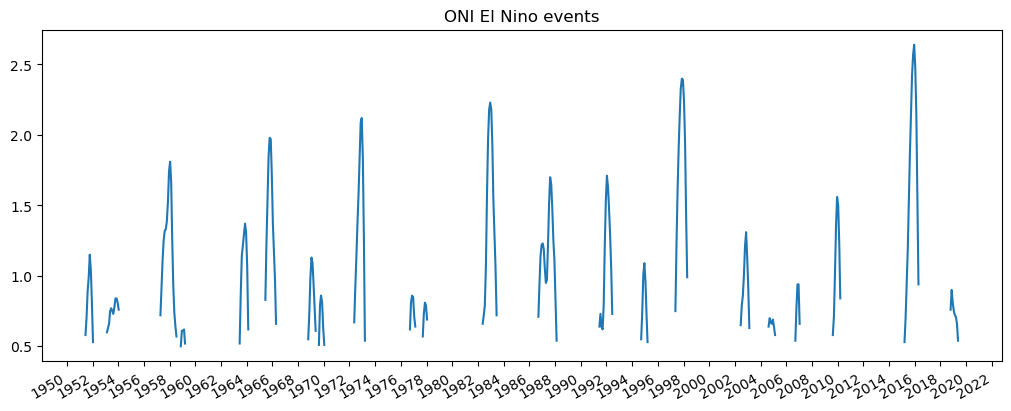

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['El Nino'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI El Nino events') 
plt.show()

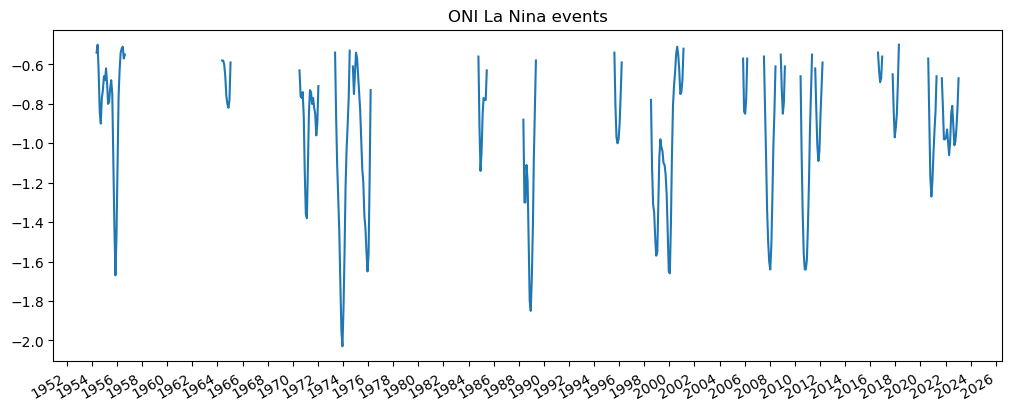

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['La Nina'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI La Nina events') 
plt.show()

## heatmap

### make table for average over certain region

In [23]:
temp_anomaly

<xarray.Dataset>
Dimensions:   (Time: 360, st_ocean: 51, xt_ocean: 3600, yt_ocean: 1500)
Coordinates:
  * Time      (Time) datetime64[ns] 1993-01-16T12:00:00 ... 2022-12-16T12:00:00
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
    month     (Time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    temp      (Time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 10, 1500, 3600), meta=np.ndarray>

In [43]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = temp_anomaly.temp.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'Time':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_of_ONI_anomaly = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_of_ONI_anomaly = spatial_mean_of_ONI_anomaly.compute()

CPU times: user 10 s, sys: 1 s, total: 11 s
Wall time: 38.3 s


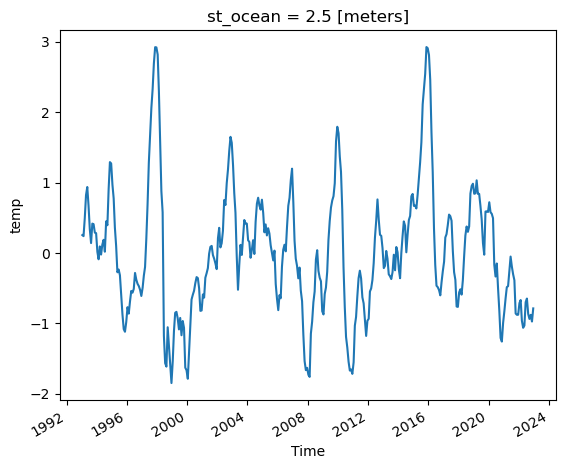

In [44]:
spatial_mean_of_ONI_anomaly.plot()

In [51]:
spatial_mean_of_ONI_anomaly_DF = spatial_mean_of_ONI_anomaly.to_dataframe()
spatial_mean_of_ONI_anomaly_DF['year'] = pd.DatetimeIndex(spatial_mean_of_ONI_anomaly_DF.index).year
spatial_mean_of_ONI_anomaly_DF

,st_ocean,month,temp,year
Time,,,,
1993-01-16 12:00:00,2.5,1,0.255235,1993
1993-02-15 00:00:00,2.5,2,0.239923,1993
1993-03-16 12:00:00,2.5,3,0.491316,1993
1993-04-16 00:00:00,2.5,4,0.822053,1993
1993-05-16 12:00:00,2.5,5,0.937453,1993
...,...,...,...,...
2022-08-16 12:00:00,2.5,8,-0.864896,2022
2022-09-16 00:00:00,2.5,9,-0.935764,2022
2022-10-16 12:00:00,2.5,10,-0.877171,2022


In [52]:
heatmap_data = spatial_mean_of_ONI_anomaly_DF.pivot_table(index='month', columns='year', values='temp')

In [53]:
heatmap_data

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
month,,,,,,,,,,,,,,,,,,,,,
1,0.255235,0.015690,0.968907,-0.768703,-0.492769,2.817869,-1.534865,-1.784969,-0.587681,0.212393,...,-0.213826,-0.234862,0.668597,2.811333,-0.122345,-0.558437,0.840971,0.721150,-0.822786,-0.711102
2,0.239923,-0.088524,0.776831,-0.860056,-0.321425,2.295861,-1.106866,-1.416627,-0.633088,0.358093,...,-0.180677,-0.357305,0.675072,2.460371,0.221036,-0.514353,0.847967,0.579761,-0.641563,-0.666962
3,0.491316,0.093737,0.360546,-0.688584,-0.197797,1.582830,-0.848049,-1.016395,-0.350456,0.079896,...,0.029498,-0.006372,0.632968,1.718212,0.268341,-0.589908,1.032360,0.557170,-0.484024,-0.960884
4,0.822053,-0.021300,0.099511,-0.538164,0.201133,0.879406,-0.835001,-0.660194,-0.287077,0.138389,...,-0.079857,0.237550,0.826899,1.149507,0.396249,-0.385830,0.839950,0.495377,-0.470431,-1.061166
5,0.937453,0.120176,-0.273497,-0.562905,0.691945,0.579174,-0.925447,-0.592766,-0.214206,0.314368,...,-0.301675,0.449518,1.060692,0.353956,0.545940,-0.052312,0.840057,-0.165420,-0.260115,-1.029243
6,0.673106,0.187943,-0.233838,-0.509503,1.284363,-1.175487,-1.083941,-0.535640,-0.009619,0.752423,...,-0.328717,0.386319,1.288176,-0.168270,0.524093,0.246985,0.671483,-0.333421,-0.050043,-0.697465
7,0.340081,0.018940,-0.314876,-0.282880,1.683615,-1.563643,-0.921439,-0.427022,0.087642,0.681835,...,-0.369237,0.010573,1.572489,-0.463709,0.458777,0.377046,0.476953,-0.148298,-0.192003,-0.646107
8,0.141533,0.450284,-0.595321,-0.378418,2.060111,-1.612657,-1.167103,-0.341701,0.101322,0.990818,...,-0.271504,0.263679,2.110776,-0.485323,0.026274,0.300992,0.140050,-0.504324,-0.302751,-0.864896
9,0.417649,0.394593,-0.870675,-0.436831,2.326096,-1.053800,-0.965122,-0.356017,-0.028959,1.186817,...,-0.024056,0.468885,2.329670,-0.525623,-0.272098,0.378010,-0.023382,-0.821247,-0.386113,-0.935764


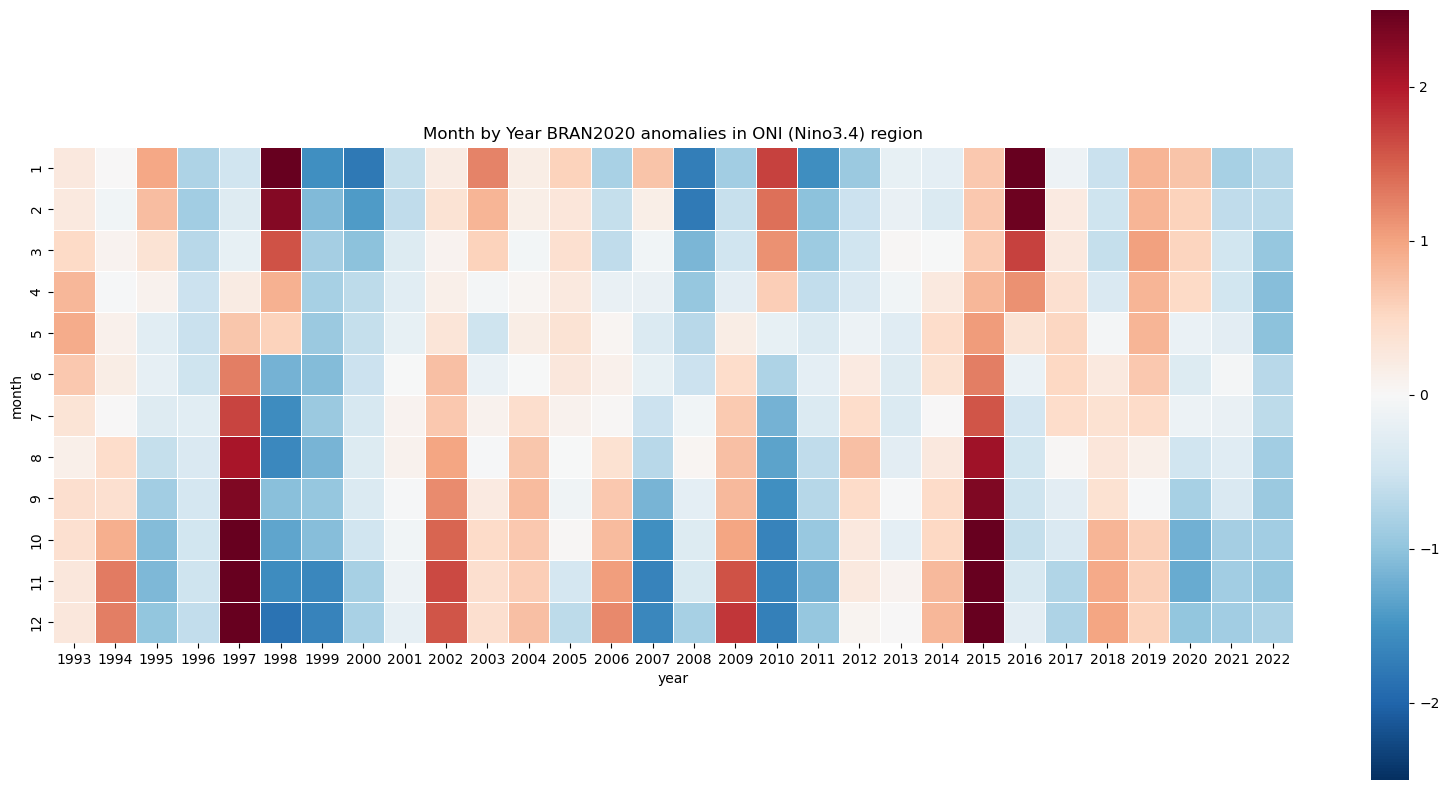

In [71]:
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region')
plt.show()

<Axes: >

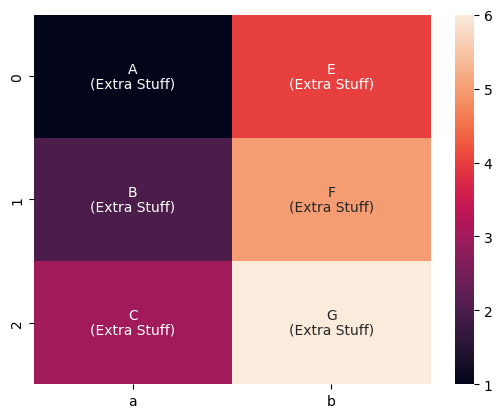

In [85]:
X = pd.DataFrame({'a':[1, 2, 3], 'b':[4, 5, 6]})
Y = pd.DataFrame({'A':['A', 'B', 'C'], 'B':['E', 'F', 'G']})
Z = pd.DataFrame({'A':['(Extra Stuff)', '(Extra Stuff)', '(Extra Stuff)'], 'B':['(Extra Stuff)', '(Extra Stuff)', '(Extra Stuff)']})

sns.heatmap(X, annot=False)
sns.heatmap(X, annot=Y, annot_kws={'va':'bottom'}, fmt="", cbar=False)
sns.heatmap(X, annot=Z, annot_kws={'va':'top'}, fmt="", cbar=False)

In [81]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']

In [98]:
event_data_EN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='El Nino',dropna=False).fillna('')
event_data_LN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='La Nina',dropna=False).fillna('')

Text(0.5, 1.0, 'Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for ENSO events')

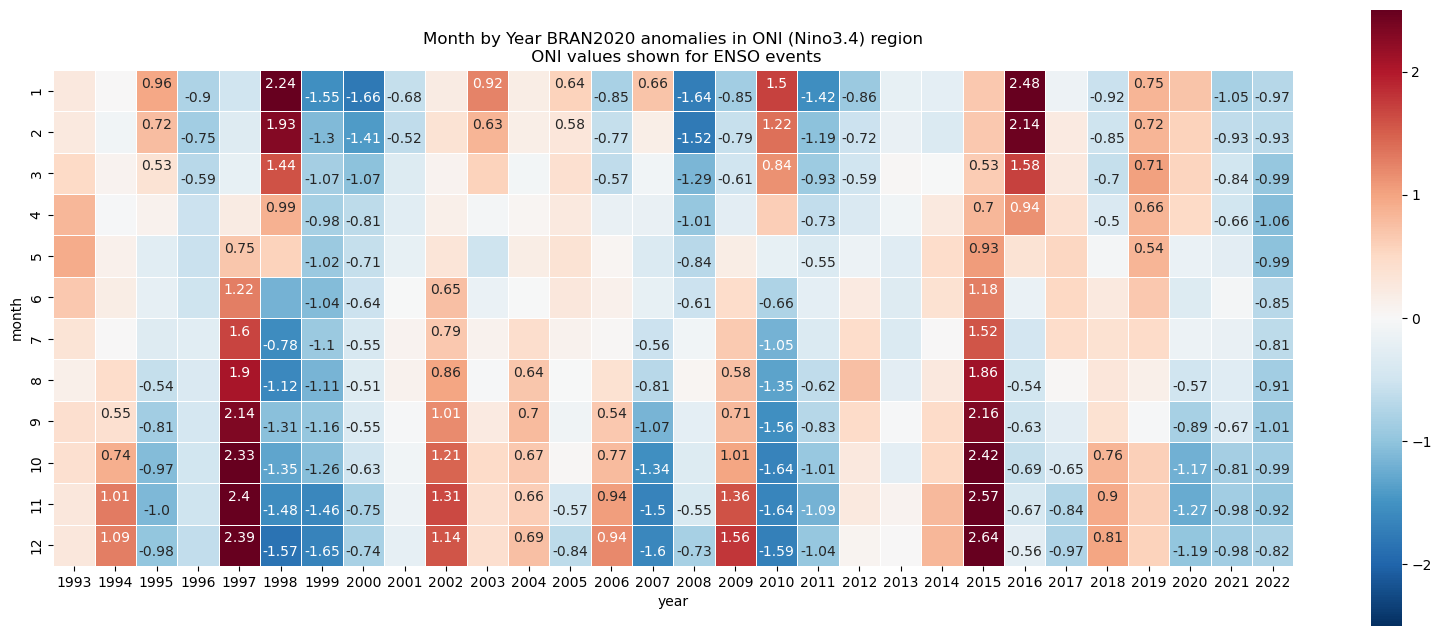

In [103]:
plt.figure(figsize=(20,8))
sns.heatmap(heatmap_data, annot=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_LN, annot_kws={'va':'top'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_EN, annot_kws={'va':'bottom'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for ENSO events')

# filter BRAN2020 data by ENSO

In [ ]:
result = ONI_DF.groupby(event_groups).agg(
    min_date=("datetime", "min"),
    max_date=("datetime", "max"),
    count=("ONI", "count")
).rename_axis(None, axis=0)

In [ ]:
result

In [ ]:
ONI_DF

In [ ]:
ONI_DF['group'] = (el_nino_threshold_months != el_nino_threshold_months.shift()).cumsum()

In [ ]:
ONI_DF['group_duration'] = ONI_DF.groupby('group')['ONI'].transform('count')

In [ ]:
ONI_DF_ENSO = ONI_DF[ONI_DF['group_duration'] > 4]


In [ ]:
print(ONI_DF_ENSO)

In [ ]:
%%time
temp_monthly_anomaly = get_monthly_anomaly(temp_chunked_time,temp_monthly_climatology, time_coord_name = 'Time')

In [ ]:
%%time
temp_monthly_anomaly = get_monthly_anomaly(temp_chunked,temp_monthly_climatology, time_coord_name = 'Time')

# What we need : just a surface slice of SST for Indo-Pacific (for example)

In [ ]:
DS_slice = DS.isel(st_ocean=0).sel({'xt_ocean':slice(90,200),'yt_ocean':slice(-50,40)})

In [ ]:
DS_slice.temp.isel(Time=0).plot()

In [ ]:
DS_slice.nbytes/1e9

## this selection is reduced to less than 1.5 GB from the 16TB total

# produce a monthly climatology

In [ ]:
%%time
clim_uv = DS_slice.groupby('Time.month').mean(method="cohorts", engine="flox")

In [ ]:
clim_uv

# This has reduced the result from a 16TB dataset to 2.5 MB so we can easily compute it into our limited memory

In [ ]:
%%time
clim_uv = clim_uv.compute()

# TLDR

## For BRAN2020 (1993 - 2022) - compute climatology of ocean currents
### 8 lines of code and less than a minute of NCI ARE walltime costing 20 cents per hour

In [ ]:
%%time
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json', columns_with_iterables=['variable']) # load catalogue
search_uv_month = BRAN2020_catalog.search(variable=['u','v'],time_period='month') # search and filter data by variables and time period
DS = search_uv_month.to_dask() # load data lazily with Dask
DS_slice = DS.sel(st_ocean= slice(0,300)).sel(xu_ocean=slice(142,160)).sel(yu_ocean=slice(-25,-10)).mean('st_ocean') # slice out reduced XYZ subset required
clim_uv = DS_slice.groupby('Time.month').mean(method="cohorts", engine="flox") ## calculate climatology & chunking rules everything!
speed = np.sqrt(clim_uv.u**2 + clim_uv.v**2) # calculate current speeds
speed.sel(month=8).plot(robust=True) #plot
plt.title('BRAN2020 current speed\n August climatology')

# The End

In [ ]:
client.shutdown()

## Plot current vectors for August

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline 

In [ ]:
%%time
# Define the u and v components of the currents
time_choice = 8
u = clim_uv.u.sel(month=time_choice)
v = clim_uv.v.sel(month=time_choice)
speed = np.sqrt(u**2 + v**2)

In [ ]:
#plot model data
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([142,160, -25, -10], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=2,alpha=0.2)
ax.set_title('BRAN2020 1993-2022\ncurrent speed \n August Climatology')